# How to use a PHYSLITE file

For the ATLAS Open Data for Research, we have released hundreds of datasets in PHYSLITE format. In this notebook we are going to show you how to access the event and variables, and how to do a basic analysis using `uproot` and `awkward` arrays.

In [1]:
# Import basic libraries
import copy # copy variables
import os   # manage paths

import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import tqdm # progress bars

In this notebook we are using a dataset from `mc20_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.deriv.DAOD_PHYSLITE.e6337_s3681_r13167_p5855`. To run this notebook locally, please download a dataset from this container and substitute the file and path in the `filename` variable below.

In [6]:
# mc20_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.deriv.DAOD_PHYSLITE.e6337_s3681_r13167_p5855
filename = "DAOD_PHYSLITE.37620644._000012.pool.root.1"
filename = "Collision Data/mc20_13TeV_MC_PhPy8EG_A14_ttbar_hdamp258p75_nonallhad_file_index.json"

## Read PHYSLITE with uproot
We can open a `TFile` using [`uproot.open`](https://uproot.readthedocs.io/en/latest/uproot.reading.open.html). To check the Ttree objects in the file we use the `.keys()` method.

In [7]:
print('TTree objects inside the ROOT file:')
for ii in uproot.open(filename).keys():
    print('-',ii)

TTree objects inside the ROOT file:
- ##Params;3
- ##Params;2
- ##Shapes;3
- ##Shapes;2
- ##Links;3
- ##Links;2
- MetaData;1
- MetaDataHdr;1
- MetaDataHdrForm;1
- CollectionTree;1
- POOLContainer;1
- POOLContainerForm;1
- POOLCollectionTree;1


To get directly a `TTree`, pass a dictionary with `{filename: treename}`. `CollectionTree` is the TTree with the events information.

In [10]:
tree = uproot.open({filename: "CollectionTree"})
tree

<TTree 'CollectionTree' (1427 branches) at 0x02727fd85090>

### List branches
Most of the data in a PHYSLITE is in the branches with "AuxDyn" in their name. This branches are type `vector<int>` or `vector<float>`, i.e. a vector of integers or floats. We can see all the branches with the `.show()` method. Here, we are only showing the first 10:

In [12]:
# Display only the first 10 branches
first_10_branches = list(tree.keys())[:10]
tree.show(filter_name=first_10_branches, name_width=50, typename_width=50, interpretation_width=50)

name                                               | typename                                           | interpretation                                    
---------------------------------------------------+----------------------------------------------------+---------------------------------------------------
xTrigDecisionAux.                                  | xAOD::TrigDecisionAuxInfo_v1                       | AsGroup(<TBranchElement 'xTrigDecisionAux.' (20...
xTrigDecisionAux./xTrigDecisionAux.xAOD::AuxInf... | unknown                                            | <UnknownInterpretation 'none of the rules match...
xTrigDecisionAux./xTrigDecisionAux.smk             | uint32_t                                           | AsDtype('>u4')
xTrigDecisionAux./xTrigDecisionAux.bgCode          | int8_t                                             | AsDtype('int8')
xTrigDecisionAux./xTrigDecisionAux.tav             | std::vector<uint32_t>                              | AsJagged(AsDtype('>u4')

### Load branches into awkward and numpy arrays

We can get a branch of a TTree by using `[branch_name]` and calling `.array()`. 

In [13]:
el_pt = tree["AnalysisElectronsAuxDyn.pt"].array()

These vector branches are represented using awkward arrays. In this case, we are getting the transverse momentum ($p_T$) of all the electrons in each event. For each event we have a variable lenght of electrons, in a total of 120,000 events.

In [7]:
el_pt

<Array [[3.69e+03], [5.13e+04], [], ..., [], []] type='120000 * var * float32'>

> Note: `120000 * var * float32` means: 120000 events, made by arrays of *var*iable lenght, comprised by floats (that represent the $p_T$ of the electrons in this case).

For plotting the $p_T$ distribution, we flatten the array to get the $p_T$ of all the electrons in a 1D array:

In [14]:
el_pt_np = ak.flatten(el_pt).to_numpy()
print(f'Total number of electrons in 120,000 events: {len(el_pt_np):,}')
el_pt_np

Total number of electrons in 120,000 events: 97,153


array([11397.472, 59129.03 , 17274.496, ..., 13611.592,  9387.799,
       13147.256], shape=(97153,), dtype=float32)

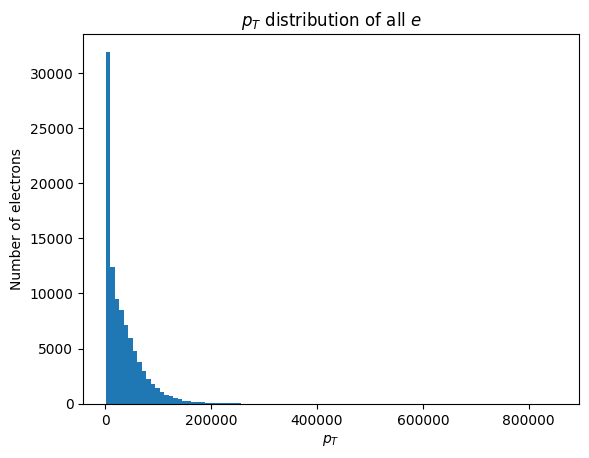

In [15]:
plt.hist(el_pt_np, bins=100)
plt.title('$p_T$ distribution of all $e$')
plt.xlabel('$p_T$')
plt.ylabel('Number of electrons')
plt.show()

## Simple analysis

To demonstrate the use of a PHYSLITE, we will work trough a very basic $t\bar{t}$ analysis. Inspired by the [Analysis Grand Challenge (AGC)](https://agc.readthedocs.io/en/latest/), the goal is to reconstruct the hadronically decaying top quark from semi-leptonic $t\bar{t}$ events. This means identifying the three jets that originated from the hadronic decay of one top quark and combining their information to estimate the quark's original properties.

![](img/ttbar.png)

### Collect branches into records
Doing the analysis using the arrays showed before would be inefficient. We are going to use the `.zip()` method from the `awkward` library. This let us can zip multiple arrays in a single structure.

For the analysis we need some information from our PHYSLITE file. We are going to get $p_T$, the pseudorapidity ($\eta$), and the azimuthal angle ($\phi$). for electrons, muons, and jets. For jets, we are also getting their mass.

In [18]:
electrons = ak.zip(
    {
        "pt": tree["AnalysisElectronsAuxDyn.pt"].array(),
        "eta": tree["AnalysisElectronsAuxDyn.eta"].array(),
        "phi": tree["AnalysisElectronsAuxDyn.phi"].array(),
    }
)

muons = ak.zip(
     {
        "pt": tree["AnalysisMuonsAuxDyn.pt"].array(),
        "eta": tree["AnalysisMuonsAuxDyn.eta"].array(),
        "phi": tree["AnalysisMuonsAuxDyn.phi"].array(),
    }
)

jets = ak.zip(
     {
        "pt": tree["AnalysisJetsAuxDyn.pt"].array(),
        "eta": tree["AnalysisJetsAuxDyn.eta"].array(),
        "phi": tree["AnalysisJetsAuxDyn.phi"].array(),
        "mass": tree["AnalysisJetsAuxDyn.m"].array(),
    }
)

We have structured our information into record arrays, where each record represents the properties of electrons/muons/jets detected in various events.

If we check the estructure of the electrons, for each electron within each event, we record three properties: 

- The outermost structure is a list, where each element corresponds to a single event. This means each item in this list represents all the electrons detected for a particular event.
- Inside each of these event lists, we have zero or more records. Each record is a dictionary that details the properties of a single electron. Specifically, the records contain:
    - pt: The transverse momentum of the electron, measured in electron volts (eV), indicating the component of the momentum perpendicular to the beam direction.
    - eta: The pseudorapidity, which is a spatial coordinate describing the angle of the particle relative to the beam axis. It helps in understanding the direction of the particle's movement.
    - phi: The azimuthal angle in the transverse plane, providing the direction of the particle around the beam axis.

For example, an empty list [] indicates an event where no electrons were detected. A non-empty list, such as [{pt: 7.65e+03, eta: -1.33, phi: -0.0518}, {pt: 3.94e+03, eta: ..., ...}], signifies an event where two electrons were detected, each with its respective $p_T$, $\eta$, and $\phi$ values detailed.

In [19]:
electrons

<Array [[{pt: 1.14e+04, eta: 0.884, ...}], ...] type='150000 * var * {pt: f...'>

The dataset contains a total of 90,000 variable-length records, each structured as follows:

```
type: 90000 * var * {
    pt: float32,
    eta: float32,
    phi: float32
}
```
This indicates that we have a dynamic array of up to 90,000 events, and for each event, there can be a variable number of electrons detected, with each electron's properties ($p_T$, $\eta$, $\phi$) stored as 32-bit floating-point numbers.

This organization allows for efficient storage and processing of the physical properties of electrons across a large number of particle collision events

We can access the fields conveniently via attribute or dictionary access:

In [21]:
electrons.pt

<Array [[1.14e+04], [5.91e+04], [], ..., [], []] type='150000 * var * float32'>

In [22]:
electrons["pt"]

<Array [[1.14e+04], [5.91e+04], [], ..., [], []] type='150000 * var * float32'>

For the jets we'll also need BTagging information. Technically this would be provided by ElementLinks (cross references), but here in PHYSLITE we have exactly one btagging value for each jet in the `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb` branch.

In [23]:
btag_prob = tree["BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb"].array()

In [24]:
ak.all(ak.num(btag_prob) == ak.num(jets))

np.True_

Since we have a value for each jet, we can just attach this as an additional field to our jets as we would do in a dictionary.

In [25]:
jets["btag_prob"] = btag_prob
jets

<Array [[{pt: 1.32e+05, ...}, ..., {...}], ...] type='150000 * var * {pt: f...'>

To facilitate convenient event selections, we organize all detected particle types—electrons, muons, and jets—into a single record array named events. This structure allows us to access all relevant data for each event in a unified manner.

Each entry in the events array corresponds to a specific collision event and contains the records for electrons, muons, and jets. It's important to note that we use `depth_limit=1` during this organization process. This parameter ensures that while the first dimension (representing individual events) is uniform in length across the dataset, the second dimension (index 1) can accommodate lists of arbitrary lengths to account for the varying number of particles detected per event.

The data is organized by electrons, muons, jets. Each of these keys within an event's record holds the list of records, defined above, for the respective particle type. If a particular type of particle was not detected in an event, its list will be empty ([]). For instance, an event with no electrons but with muons and jets will have an empty list for electrons and populated lists for muons and jets.

An example entry might look like this:

```
{
  Electrons: [{pt: ..., eta: ..., phi: ...}, ...],
  Muons: [{pt: ..., eta: ..., phi: ...}, ...],
  Jets: [{pt: ..., eta: ..., phi: ..., mass: ..., btag_prob: ...}, ...]
}
```


In [26]:
events = ak.zip({"Electrons": electrons, "Muons": muons, "Jets": jets}, depth_limit=1)
events

<Array [{Electrons: [{...}], ...}, ..., {...}] type='150000 * {Electrons: v...'>

This organizational scheme, encapsulated as:
```
type: 90000 * {
    Electrons: var * {
        pt: float32,
        eta: float32,
        phi: float32
    },
    Muons: var * {
        pt: float32,
        eta: float32,
        phi: float32
    },
    Jets: var * {
        pt: float32,
        eta: float32,
        phi: float32,
        mass: float32,
        btag_prob: float32
    }
}
```
describes a dataset of 90,000 events, where each event can contain a variable number of Electrons, Muons, and Jets. Each particle's properties are stored as 32-bit floating-point numbers.

### Event and object selection
- **At least 4 Jets Required:** In a $t\bar{t}$ event, one top quark decays hadronically (into three jets) while the other decays leptonically (into a lepton and a b-jet alongside a neutrino). The requirement for at least four jets reflects the need to capture both decay channels. Specifically, one jet is expected from the leptonic decay (the b-jet) and three from the hadronic decay.

- **Exactly One Electron or Muon:** This particle should have reasonably high $p_T$ and be centrally located within the detector (indicating its $\eta$ is within a central range). The presence of exactly one high-$p_T$, centrally-located electron or muon ensures we're observing a semi-leptonic $t\bar{t}$ decay, where one top quark decays into a lepton (electron or muon), a neutrino, and a b-jet. This criterion helps filter events that closely match the expected signature of a $t\bar{t}$ event.

- **B-tagging with 85% Working Point:** B-tagging is a technique used to identify jets originating from b-quarks. The "85% working point" refers to a specific threshold in the b-tagging algorithm that offers an 85% probability of correctly identifying b-jets. Choosing this working point balances the need for high b-jet identification efficiency with the control of mistakenly tagging light-quark or gluon jets as b-jets (misidentification rate).

- **At Least 2 B-jets:** Since both top quarks in a $t\bar{t}$ event decay into a b-quark (one directly in the hadronic decay and one as part of the leptonic decay chain), identifying at least two b-jets in an event is crucial. This ensures that the selection process captures the events that likely represent the decay products of a pair of top quarks.

By adhering to these selection criteria, the analysis aims to filter the dataset for events that are most representative of semi-leptonic $t\bar{t}$ decays, facilitating a focused and efficient study of the hadronically decaying top quark.

#### Basic object selections

The object selection is done using boolean masks—a way to select only those elements that meet our criteria. Selections work like in `numpy`, by passing a boolean mask like `[mask]`. A boolean mask is essentially an array where each element is either True (if the condition is met) or False (if the condition is not met). When applied to the dataset, it filters out only the True elements.

We define a condition (e.g., electrons.pt > 30 * GeV) to create a mask. This condition checks if the transverse momentum of each electron is greater than 30 GeV (where GeV = 1000. is a unit conversion factor). The result is a boolean mask array indicating with True or False whether each electron in each event meets the condition.

In [27]:
GeV = 1000.
mask = electrons.pt > 30 * GeV
mask

<Array [[False], [True], [], ..., [False], [], []] type='150000 * var * bool'>

Applying the mask to the electrons array (electrons[mask]) filters out only those electrons that meet the condition. If none meet the condition, the result for that event is an empty list. This process generalizes to lists, allowing us to work with vector branches.

In [29]:
electrons[mask]

<Array [[], [{pt: 5.91e+04, ...}], ..., [], []] type='150000 * var * {pt: f...'>

We define functions (selected_electrons, selected_muons, selected_jets) to encapsulate the selection logic. These functions return only the particles from each event that meet both conditions:
- Their $p_T$ is greater than 30 GeV.
- Their $\eta$ is within a certain range ($|\eta| < 2.47$), ensuring they are centrally located within the detector.

In [31]:
def selected_electrons(el):
    return el[(el.pt > 30 * GeV) & (abs(el.eta) < 2.47)]

def selected_muons(mu):
    return mu[(mu.pt > 30 * GeV) & (abs(mu.eta) < 2.47)]

def selected_jets(j):
    return j[(j.pt > 30 * GeV) & (abs(j.eta) < 2.47)]

We apply these selections to all our objects in the `events` record:

In [32]:
events["Electrons"] = selected_electrons(electrons)
events["Muons"] = selected_muons(muons)
events["Jets"] = selected_jets(jets)

In [33]:
print(f'Number of electrons before selection: {ak.count(electrons.pt):,}')
print(f'Number of electrons after selection: {ak.count(events.Electrons.pt):,}')

Number of electrons before selection: 97,153
Number of electrons after selection: 39,885


#### Lorentz vectors
The vector package in Python provides tools to treat collections of particle properties as vectors. This is particularly useful for performing geometric and kinematic calculations, such as transformations and invariant mass calculations. 

We start by converting the properties of particles (Electrons, Muons, Jets) into Lorentz vectors. This involves associating their physical properties (e.g., transverse momentum, pseudorapidity, azimuthal angle) with the components of a vector. The function `vector.awk()` is applied to the properties of Electrons, Muons, and Jets. This operation effectively converts the data structure holding the particles' properties into one that supports vector operations.

In [34]:
events["Electrons"] = vector.awk(events.Electrons)
events["Muons"] = vector.awk(events.Muons)
events["Jets"] = vector.awk(events.Jets)

In [35]:
events.Electrons

<MomentumArray3D [[], [{rho: 5.91e+04, ...}], ..., []] type='150000 * var *...'>

After conversion, you can access specific vector components directly. For instance, accessing the $p_x$ component (the x-component of the momentum vector) of each electron becomes straightforward.

In [36]:
events.Electrons.px

<Array [[], [-1.3e+04], [], [], ..., [], [], []] type='150000 * var * float32'>

#### Overlap removal

Overlap removal is an essential step in particle physics analyses to ensure that the same physical object is not misidentified as multiple types of particles. When particles like electrons and jets are detected close to each other in the detector, it can create ambiguity about their identities. This section explains how to identify and remove such overlaps, focusing on the overlap between electrons and jets.

##### Understanding Overlap Removal
1. **Identifying Overlaps with Cartesian Product**:

    The process begins by considering all possible pairs (combinations) of electrons and jets within each event. This is known as creating a Cartesian product.
    `ak.cartesian([events.Jets, events.Electrons], nested=True)` generates all combinations of jets and electrons. The `nested=True` parameter adds an additional dimension to the array, which represents each possible pair of jet and electron. 

    The result of `ak.cartesian` is then split into two arrays (`jj` for jets and `ee` for electrons) using `ak.unzip`. This effectively separates the pairs into corresponding jets and electrons arrays but keeps them linked by their indices within these arrays.

2. **Calculating the Separation with $\Delta R$**:

    The next step involves calculating the separation between each jet-electron pair. This separation is quantified using a metric called $\Delta R$, which combines differences in their azimuthal angle ($\phi$) and pseudorapidity ($\eta$) into a single distance measure. `jj.deltaR(ee)` calculates the $\Delta R$ between each jet and electron in the pairs generated. Plotting the histogram of $\Delta R$ values for all jet-electron pairs gives insight into how closely jets and electrons are located to each other in the detector.

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
C:\Users\netal\AppData\Local\Temp\ipykernel_8272\749718551.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta R(j, e)$ (for all jet - electron pairs)")
C:\Users\netal\AppData\Local\Temp\ipykernel_8272\749718551.py:5: SyntaxWarning: invalid escape sequence '\D'
  plt.title('Distribution of $\Delta R$ Between Jets and Electrons')


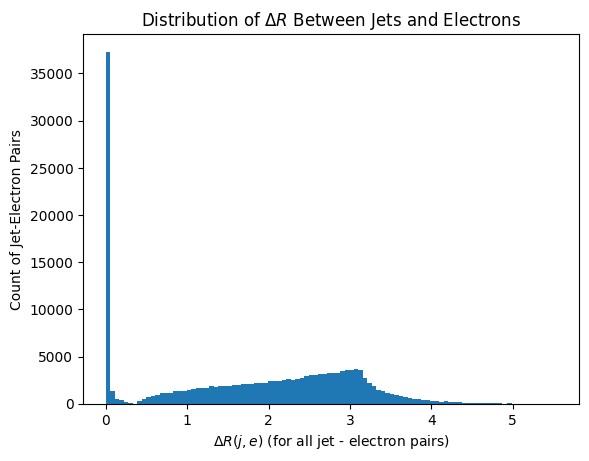

In [37]:
jj, ee = ak.unzip(ak.cartesian([events.Jets, events.Electrons], nested=True))
plt.hist(ak.flatten(jj.deltaR(ee), axis=None).to_numpy(), bins=100)
plt.xlabel("$\Delta R(j, e)$ (for all jet - electron pairs)")
plt.ylabel("Count of Jet-Electron Pairs")
plt.title('Distribution of $\Delta R$ Between Jets and Electrons')
plt.show()

3. **Defining and Applying Overlap Removal Criteria**:
    A common criterion for overlap removal is to exclude jets that are within a certain $\Delta R$ distance from an electron, typically $\Delta R < 0.4$.
    The function `no_overlap(obj1, obj2, deltaR=0.4)` checks for each jet if there is any electron within a $\Delta R$ of 0.4. It uses `ak.all(obj1.deltaR(obj2) > deltaR, axis=-1)` to return a boolean mask where True indicates a jet does not overlap any electron by this criterion. This mask can then be applied to the jets array to filter out those jets that are too close to electrons, ensuring they are not double-counted as both jets and electrons.

In [39]:
def no_overlap(obj1, obj2, deltaR=0.4):
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))
    return ak.all(obj1.deltaR(obj2) > deltaR, axis=-1)

After defining the no_overlap function, it's used to create a mask for jets that do not overlap with electrons:

In [40]:
no_overlap(events.Jets, events.Electrons) # mask for each jet if it has no overlap with any electron

<Array [[True, True, True], ..., [True, True]] type='150000 * var * bool'>

This mask is then applied to the jets in the events:

In [41]:
events["Jets"] = events.Jets[no_overlap(events.Jets, events.Electrons)]

This step updates the events dataset to only include jets that have passed the overlap removal criteria, ensuring a cleaner separation of particle types.

#### Apply event selection
After cleaning the dataset through overlap removal, applying event selection criteria helps isolate the events that are most relevant to the specific analysis goal. In this case, the criteria are tailored for $t\bar{t}$ analysis, and were explained above:
- At least 4 Jets
- Exactly One Lepton (Electron or Muon)
- At Least Two B-tagged Jets with Prob > 0.85

In [42]:
events["Jets", "is_bjet"] = events.Jets.btag_prob > 0.85

events = events[
    (ak.num(events.Jets) >= 4) # at least 4 jets
    & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly one lepton
    & (ak.num(events.Jets[events.Jets.is_bjet]) >= 2) # at least two btagged jets with prob > 0.85
]

In [43]:
print(f'Initially we had 120,000 events. After the event selection we have {len(events):,} events')

Initially we had 120,000 events. After the event selection we have 7,351 events


### Top quark reconstruction

As we progress through our $t\bar{t}$ analysis, the next critical step involves reconstructing the top quark from the decay products observed in our events. This section outlines a streamlined approach to piecing together the decay signature of the top quark from jet combinations, focusing on key criteria that align with the characteristics of top quark decays.

#### Procedure for Top Quark Reconstruction:
1. **Combining Jets**:
    We start by generating all possible combinations of three jets within each event. This step is foundational, considering the typical hadronic decay of a top quark results in three jets.

2. **Incorporating B-jets**:
    To refine our combinations, we require that at least one jet in each combination is b-tagged (`is_bjet`). This reflects the decay pathway of the top quark, where one jet is expected to originate from a b quark.
    
3. **Identifying the Best Candidate**:
    Among these combinations, we then identify the one with the highest total $p_T$. This criterion helps select the combination most likely to represent the decay products of a top quark, based on the assumption that the decay of a massive particle like the top quark would produce high-momentum jets.

### Implementation Through the mjjj Function:
- **Creating Combinations**: Utilizes `ak.combinations(jets, 3)` to form every 3-jet group.
- **Unpacking Jets**: Through `ak.unzip(candidates)`, the individual jets in each combination are extracted.
- **Filtering for B-jets**: Ensures combinations include at least one b-jet by evaluating `(j1.is_bjet + j2.is_bjet + j3.is_bjet) > 0`.
- **4-Momentum Calculation**: Computes the total 4-momentum for each jet trio, `candidates["p4"] = j1 + j2 + j3`.
- **Selection of Top Candidate**: Chooses the jet combination with the highest pt as the top quark candidate, extracting its mass for the reconstruction.

In [44]:
def mjjj(jets):
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    has_b = (j1.is_bjet + j2.is_bjet + j3.is_bjet) > 0
    candidates["p4"] = j1 + j2 + j3
    candidates = candidates[has_b]
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return candidates.p4.mass

Visualizing these masses through a histogram provides insights into the effectiveness of the reconstruction method and the characteristics of the top quark decays within our dataset. The most prominent feature to look for is a peak in the distribution that corresponds to the known mass of the top quark. The mass of the top quark is approximately 172.76 GeV/c². Therefore, a peak around this value indicates successful reconstruction of top quarks from the decay products.

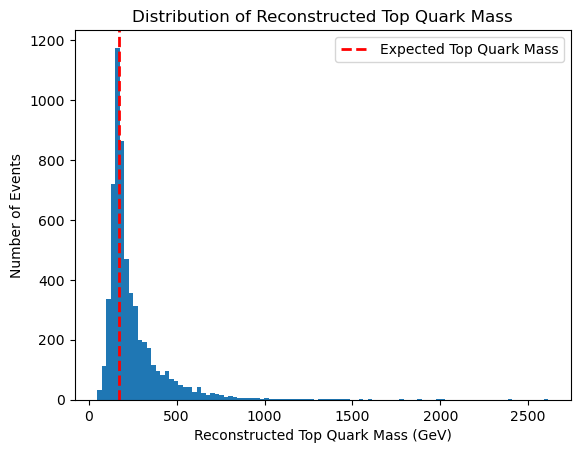

In [33]:
plt.hist(ak.flatten(mjjj(events.Jets) / GeV, axis=None), bins=100)
plt.xlabel("Reconstructed Top Quark Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Top Quark Mass")
plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
plt.legend()
plt.show()

### Run on larger number of files

When scaling up data analysis to handle larger datasets, especially in high-energy physics where datasets can be enormous, managing memory usage becomes crucial to prevent running out of memory (OOM) errors. Here's a clearer explanation of the strategies mentioned for handling large-scale data processing efficiently:

#### Chunking the Processing
This approach involves dividing the dataset into smaller, manageable pieces or "chunks" and processing each chunk sequentially. After processing a chunk, the results can be aggregated (e.g., accumulating in a histogram or ntuple), and the memory used by the chunk can be released before moving on to the next chunk. This method helps in managing memory usage effectively by ensuring that only a portion of the data is held in memory at any given time.

- Advantages: Simple to implement and can significantly reduce memory usage.
- Use Case: Particularly useful when operations on individual chunks are independent and can be aggregated easily.

#### Distributed Processing
Distributed processing involves spreading the data and computations across multiple machines or processors. This not only helps in managing memory by leveraging the collective memory of multiple systems but also can speed up the processing by executing tasks in parallel. We won't discuss distributed processing in this tutorial, but there are nice possibilities to do this while still staying interactive by using [`dask`](https://www.dask.org/)

#### Processing Data in Chunks with Awkward Array
For the specific case of processing large datasets of particle physics events, where the analysis might discard a significant number of events and only a subset of data columns are retained, processing data in chunks becomes highly efficient. Here's how you can do it:

- **Process Each File Separately**: Instead of loading the entire dataset into memory, process each file one at a time. This limits the amount of data in memory to what's contained in a single file.
- **Use `ak.to_packed` for Memory Efficiency**: After applying event selection and filtering out unnecessary data, the ak.to_packed function can be used to further reduce memory usage. This function optimizes the memory layout of the Awkward Array by eliminating unused spaces (from masks and indices) and ensuring that only the memory needed for the retained data is used.

In [47]:
memory_usage_kiB = ak.to_packed(events).nbytes / 1024
print(f"Memory usage: {memory_usage_kiB:.5} kiB")

Memory usage: 966.47 kiB


This calculation gives you an estimate of the memory usage after compaction.


#### Organize code into functions
First, we structure everything a bit more nicely into functions

##### Defining a Schema
The schema dictionary outlines the data structure expected from the input files. It maps each particle type (Electrons, Muons, Jets, and BTagging information) to the relevant attributes that will be read and processed. This schema is crucial for dynamically handling different data fields across various particle types.

In [49]:
schema = {
    "Electrons": [
        "pt", "eta", "phi",
    ],
    "Muons": [
        "pt", "eta", "phi",
    ],
    "Jets": [
        "pt", "eta", "phi", "m"
    ],
    "BTagging_AntiKt4EMPFlow": [
        "DL1dv01_pb",
    ]
}

##### `read_events` Function
Reads data from a file according to the specified schema, organizing the data into a structured format suitable for analysis.

**Process:**
- Opens a file using uproot and iterates over the schema to read specified fields for each particle type.
- Uses `ak.zip` to combine the fields into structured arrays, preserving the relationship between different attributes of each particle type.
- Returns a structured awkward array (`ak.zip(events, depth_limit=1)`) that encapsulates the event data, allowing for efficient, high-level operations on the dataset.

In [50]:
def read_events(filename, schema):
    with uproot.open({filename: "CollectionTree"}) as tree:
        events = {}
        for objname, fields in schema.items():
            base = objname
            if objname in ["Electrons", "Muons", "Jets"]:
                base = "Analysis" + objname
                ak_zip = vector.zip
            else:
                ak_zip = ak.zip
            arrays = tree.arrays(
                fields,
                aliases={field: f"{base}AuxDyn.{field}" for field in fields},
            )
            arrays = ak_zip(dict(zip(arrays.fields, ak.unzip(arrays))))
            events[objname] = arrays
        return ak.zip(events, depth_limit=1)

In [52]:
events = read_events(filename, schema)
events

<Array [{Electrons: [{...}], ...}, ..., {...}] type='150000 * {Electrons: v...'>

##### `processed` Function
Applies a series of processing steps to the events data to prepare it for analysis. This includes applying selection criteria and organizing data for efficient memory usage.

**Process:**
- Makes a shallow copy of the events to avoid mutating the original data.
- Adds a `btag_prob` field to Jets based on BTagging information.
- Applies selection functions (`selected_electrons`, `selected_muons`, `selected_jets`) to filter particles based on specific criteria (e.g., transverse momentum and pseudorapidity).
- Removes overlapping jets with selected electrons to avoid double counting.
- Flags jets as b-tagged jets (`is_bjet`) based on their b-tagging probability.
- Applies event selection criteria to filter the events further, retaining those with at least four jets, exactly one lepton (electron or muon), and at least two b-tagged jets.
- Compacts the data using ak.`to_packed` to reduce memory usage, discarding unnecessary indices and masks.

It returns a processed and compacted dataset, ready for further analysis, with significantly reduced memory footprint.

In [54]:
def processed(events):
    events = copy.copy(events) # shallow copy
    events["Jets", "btag_prob"] = events.BTagging_AntiKt4EMPFlow.DL1dv01_pb
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Jets"] = selected_jets(events.Jets)
    events["Jets"] = events.Jets[no_overlap(events.Jets, events.Electrons)]
    events["Jets", "is_bjet"] = events.Jets.btag_prob > 0.85
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly one lepton
        & (ak.num(events.Jets[events.Jets.is_bjet]) >= 2) # at least two btagged jets with prob > 0.85
    ]
    return ak.to_packed(events)

In [55]:
processed(events)

<Array [{...}, {...}, {...}, ..., {...}, {...}] type='7351 * {BTagging_Anti...'>

### Pause a second and talk about performance
We're taking a moment to discuss performance, specifically focusing on how time is allocated during different stages of data handling in a particle physics analysis workflow. By examining the time spent reading data into memory and processing it, we gain insights into potential bottlenecks and areas for optimization.

#### Time for reading arrays into memory
It takes approximately 3.29 seconds to read arrays into memory. This measurement gives us a baseline for the time complexity associated with loading data from a file using the specified schema. 

For this specific example, which involves a relatively small file and a limited number of data branches (fields), a significant portion of the time is not spent on transferring large volumes of data into memory. Instead, it is mostly consumed by metadata operations, such as fetching the TTree object and accessing branch information. This overhead is intrinsic to the file format and the way data is stored and accessed.

In [58]:
%timeit read_events(filename, schema)

KeyboardInterrupt: 

#### Time Spent Opening the File
By isolating the action of merely opening the file and accessing the TTree object (only_open()), we find it takes about 1 second. This step does not involve reading any data into memory; it merely sets up access to the data.

This result highlights that a significant fraction of the total read time is dedicated to overhead associated with file and data structure access in ROOT files. The implication is that improvements in how metadata is handled could lead to better performance.

In [59]:
def only_open():
    with uproot.open({filename: "CollectionTree"}) as tree:
        return tree

In [60]:
%timeit only_open()

KeyboardInterrupt: 

#### Time Spent on Processing

The processing step, quantified by `%timeit processed(events)`, is notably faster, taking only about 170 milliseconds. This difference emphasizes that once the data is in memory, computations and manipulations of the data (such as applying selection criteria and organizing data structures) are highly efficient.

In [43]:
%timeit processed(events)

170 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The comparison suggests that for small files or when accessing a limited number of branches, the overhead of dealing with metadata can dominate the time spent. This is an important consideration for performance optimization, particularly in workflows that involve many small files or require frequent access to different data branches.

## Transforming PHYSLITE into N-Tuple
The [N-tuple](https://opendata.atlas.cern/docs/documentation/data_format/ntuple) structure is widely used for physics analyses. One way to use the PHYSLITE files is by transforming it into a N-tuple. For more information on the topic, you can check the [ATLAS Analysis Software Tutorial](https://atlassoftwaredocs.web.cern.ch/ASWTutorial/), particularly [Writing NTuples and Trees using the Text Configuration](https://atlassoftwaredocs.web.cern.ch/AnalysisSWTutorial/cpalg_ntuple/).